In [2]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [9]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [13]:
sample = True

if sample:
    path = "data_sample/"
else:
    path = "data/"
    
model_path = "models/"
batch_size = 64

In [14]:
model = vgg_ft(2)

In [15]:
model.load_weights(model_path+'finetune3.h5')

In [16]:
layers = model.layers

Get the last convolutional layer in the network.

In [17]:
last_conv_idx = [index for index, layer in enumerate(layers) if type(layer) is Convolution2D][-1]

In [18]:
last_conv_idx

30

In [19]:
layers[last_conv_idx]

In [43]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
fc_layers = layers[last_conv_idx+1:]

Create a validation batch and a training batch, as well as train/validation output in terms of class label and one-hot encoded output.

In [44]:
batches = get_batches(path+"train", shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+"valid", shuffle=False, batch_size=batch_size)

trn_classes = batches.classes
val_classes = val_batches.classes

trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

Found 4677 images belonging to 2 classes.
Found 1591 images belonging to 2 classes.


In [25]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

Save the arrays for fast retrieval

In [32]:
save_array(model_path+'val_convlayer_features.bc', val_features)
save_array(model_path+'trn_convlayer_features.bc', trn_features)

In [33]:
val_features = load_array(model_path+'val_convlayer_features.bc')
trn_features = load_array(model_path+'trn_convlayer_features.bc')

In [35]:
trn_features.shape

(4677, 512, 14, 14)

Create a new model that removes dropout.

In [55]:
# why is this an array?
def proc_weights(layer): return [o/2 for o in layer.get_weights()]

In [56]:
opt = RMSprop(lr=0.00001, rho=0.7)

In [57]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
    ])
    
    for l1, l2 in zip(model.layers, fc_layers): l1.set_weights(proc_weights(l2))
        
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [58]:
fc_model = get_fc_model()

In [59]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, batch_size=batch_size,
             validation_data=(val_features, val_labels))

Train on 4677 samples, validate on 1591 samples
Epoch 1/8
4677/4677 [==============================] - 7s - loss: 0.3104 - acc: 0.9780 - val_loss: 0.2232 - val_acc: 0.9824
Epoch 2/8
4677/4677 [==============================] - 7s - loss: 0.2020 - acc: 0.9852 - val_loss: 0.3117 - val_acc: 0.9767
Epoch 3/8
4677/4677 [==============================] - 7s - loss: 0.1727 - acc: 0.9872 - val_loss: 0.2904 - val_acc: 0.9786
Epoch 4/8
4677/4677 [==============================] - 7s - loss: 0.0902 - acc: 0.9932 - val_loss: 0.2304 - val_acc: 0.9793
Epoch 5/8
4677/4677 [==============================] - 7s - loss: 0.0673 - acc: 0.9949 - val_loss: 0.2390 - val_acc: 0.9837
Epoch 6/8
4677/4677 [==============================] - 7s - loss: 0.0474 - acc: 0.9968 - val_loss: 0.2144 - val_acc: 0.9824
Epoch 7/8
4677/4677 [==============================] - 7s - loss: 0.0502 - acc: 0.9968 - val_loss: 0.2338 - val_acc: 0.9849
Epoch 8/8
4677/4677 [==============================] - 7s - loss: 0.0482 - acc: 0.99

In [61]:
fc_model.save_weights(model_path+"no_dropout.h5")
fc_model.load_weights(model_path+"no_dropout.h5")

Define a generator that includes data augmentation.

In [94]:
gen = image.ImageDataGenerator(rotation_range=10, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1,
#                                width_zoom_range=0.2, 
                               shear_range=0.15, 
                               zoom_range=0.1, 
                               channel_shift_range=10.,
                               horizontal_flip=True, 
                               dim_ordering='tf')

Let's use this data augmentation generator on a single image. 

In [95]:
img = np.expand_dims(ndimage.imread('data/test/7.jpg'),0)

In [96]:
aug_iter = gen.flow(img)

In [97]:
aug_imgs = [next(aug_iter)[0] for i in range(8)]

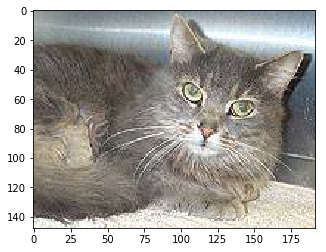

In [98]:
plt.imshow(img[0])

In [99]:
next(aug_iter)[0].shape

(148, 192, 3)

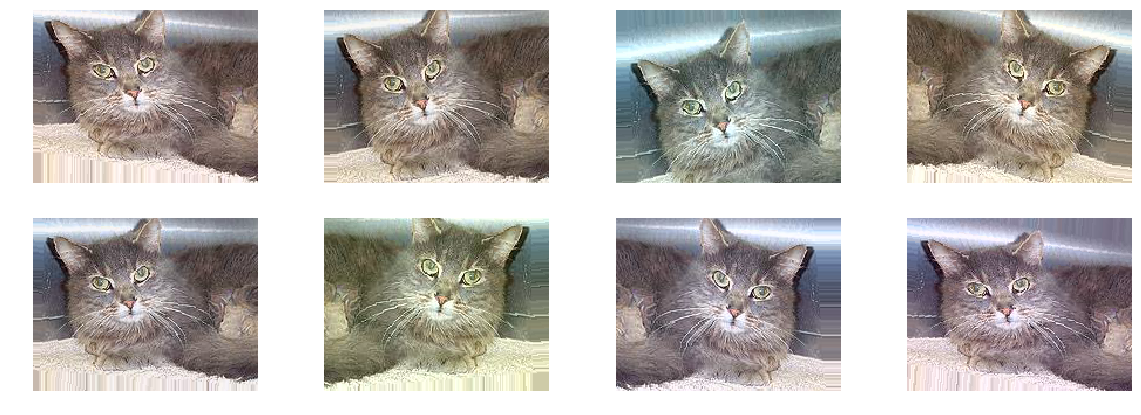

In [100]:
plots(aug_imgs, (20,7), 2)

In [101]:
K.set_image_dim_ordering('th')

Let's add some augmentation to our model.

In [102]:
gen = image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [103]:
batches = get_batches(path+"train", gen, shuffle=True, batch_size=batch_size)
val_batches = get_batches(path+"valid", gen, shuffle=False, batch_size=batch_size)

Found 4677 images belonging to 2 classes.
Found 1591 images belonging to 2 classes.


In [104]:
fc_model = get_fc_model()

for layer in conv_model.layers: layer.trainable = False

conv_model.add(fc_model)

In [105]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
conv_model.fit_generator(batches, batches.nb_sample, nb_epoch=8, validation_data=val_batches,
                         nb_val_samples=val_batches.nb_sample)

Epoch 1/8
4677/4677 [==============================] - 160s - loss: 0.3748 - acc: 0.9707 - val_loss: 0.3412 - val_acc: 0.9723
Epoch 2/8
4677/4677 [==============================] - 160s - loss: 0.3166 - acc: 0.9773 - val_loss: 0.2217 - val_acc: 0.9830
Epoch 3/8
4677/4677 [==============================] - 160s - loss: 0.2342 - acc: 0.9820 - val_loss: 0.3559 - val_acc: 0.9717
Epoch 4/8
4677/4677 [==============================] - 160s - loss: 0.2169 - acc: 0.9820 - val_loss: 0.2975 - val_acc: 0.9780
Epoch 5/8
4677/4677 [==============================] - 161s - loss: 0.2421 - acc: 0.9827 - val_loss: 0.3243 - val_acc: 0.9780
Epoch 6/8
4677/4677 [==============================] - 161s - loss: 0.1698 - acc: 0.9874 - val_loss: 0.3224 - val_acc: 0.9767
Epoch 7/8
4677/4677 [==============================] - 161s - loss: 0.1576 - acc: 0.9882 - val_loss: 0.2116 - val_acc: 0.9824
Epoch 8/8
4677/4677 [==============================] - 161s - loss: 0.1596 - acc: 0.9876 - val_loss: 0.3891 - val_acc:

In [107]:
conv_model.save_weights(model_path+"aug1.h5")
conv_model.load_weights(model_path+"aug1.h5")

In [108]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [109]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
    ]

In [153]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights from the model from the dense layers of the Vgg16BN model."
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [154]:
p=0.6

In [155]:
bn_model = Sequential(get_bn_layers(0.6))

In [156]:
load_fc_weights_from_vgg16bn(bn_model)

In [157]:
def proc_weights(layer, prev_p, new_p):
    scal = (1 - prev_p)/(1 - new_p)
    return [o*scal for o in layer.get_weights()]

In [158]:
for l in bn_model.layers:
    if type(l) == Dense: l.set_weights(proc_weights(l, 0.5, 0.6))

In [159]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable = False

In [160]:
bn_model.add(Dense(2, activation='softmax'))

In [161]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [162]:
bn_model.fit(trn_features, trn_labels, batch_size=batch_size, 
             nb_epoch=8, validation_data=(val_features, val_labels))

Train on 4677 samples, validate on 1591 samples
Epoch 1/8
4677/4677 [==============================] - 2s - loss: 0.3617 - acc: 0.9258 - val_loss: 0.0790 - val_acc: 0.9818
Epoch 2/8
4677/4677 [==============================] - 2s - loss: 0.2116 - acc: 0.9613 - val_loss: 0.0553 - val_acc: 0.9824
Epoch 3/8
4677/4677 [==============================] - 2s - loss: 0.1914 - acc: 0.9643 - val_loss: 0.0732 - val_acc: 0.9805
Epoch 4/8
4677/4677 [==============================] - 2s - loss: 0.2114 - acc: 0.9600 - val_loss: 0.0901 - val_acc: 0.9805
Epoch 5/8
4677/4677 [==============================] - 2s - loss: 0.1787 - acc: 0.9673 - val_loss: 0.0727 - val_acc: 0.9799
Epoch 6/8
4677/4677 [==============================] - 2s - loss: 0.2066 - acc: 0.9690 - val_loss: 0.0672 - val_acc: 0.9793
Epoch 7/8
4677/4677 [==============================] - 2s - loss: 0.1780 - acc: 0.9664 - val_loss: 0.0865 - val_acc: 0.9805
Epoch 8/8
4677/4677 [==============================] - 2s - loss: 0.2204 - acc: 0.96

In [163]:
bn_model.save_weights(model_path+"bn.h5")
bn_model.load_weights(model_path+"bn.h5")

In [164]:
bn_layers = get_bn_layers(0.6)

In [171]:
bn_layers.pop()

In [172]:
bn_layers.append(Dense(2, activation='softmax'))

In [173]:
final_model = Sequential(conv_layers)

In [174]:
for layer in final_model.layers: layer.trainable = False

In [175]:
for layer in bn_layers: final_model.add(layer)

In [176]:
for l1, l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [177]:
final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [179]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                          validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
4677/4677 [==============================] - 162s - loss: 0.8996 - acc: 0.9305 - val_loss: 0.7826 - val_acc: 0.9478


In [181]:
final_model.save_weights(model_path+"final2.h5")

In [182]:
final_model.optimizer.lr=0.001

In [183]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                          validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
4677/4677 [==============================] - 162s - loss: 0.7409 - acc: 0.9457 - val_loss: 0.5493 - val_acc: 0.9604
Epoch 2/4
4677/4677 [==============================] - 161s - loss: 0.5362 - acc: 0.9594 - val_loss: 0.5241 - val_acc: 0.9617
Epoch 3/4
4677/4677 [==============================] - 161s - loss: 0.4527 - acc: 0.9658 - val_loss: 0.4661 - val_acc: 0.9673
Epoch 4/4
4677/4677 [==============================] - 161s - loss: 0.4721 - acc: 0.9632 - val_loss: 0.5194 - val_acc: 0.9560


In [184]:
final_model.save_weights("final3.h5")